In [267]:
import numpy as np

import matplotlib.pyplot as plt

import nltk

import spacy
from spacy_langdetect import LanguageDetector

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [254]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


In [ ]:
path = 'data/cleaned.npy'
arr = np.load(path, allow_pickle = True)

In [7]:
arr.shape

(40627, 4)

In [20]:
words = arr[:,3]

In [63]:
nlp = spacy.load("en")
nlp.add_pipe(LanguageDetector(), name="language_detector", last=True)

lang = []
for idx, w in enumerate(words):
    if len(w)<4:
        lang.append(-1)
    else:
        doc = nlp(w)
        lang.append(doc._.language['language'])
    progress_bar = idx
    update_progress((idx+1) / len(words))
    




Progress: [####################] 100.0%


In [65]:
len(words)

40627

In [72]:
l =np.array(lang)
l.shape
l =l.reshape(-1,1)

In [77]:
arr2 = np.concatenate((arr,l), axis = 1 )

In [78]:
arr2.shape

(40627, 5)

In [81]:
arr2[3]

array([5, '1927303-mary', ('Paperback 9781435756342',),
       'Live love laugh a Lot is a special book.Interesting characters make you laugh- you must take a look.Voicing their opinions in humorous forms moving line by line.Entertaining to such an extent- you must take your time.Love the way Jacquelyn speaks through Sly Fox.Over and over you have to laugh as he comes out of his box.Very sly he tries to be from behind his cloth.Excitement on each page you must laugh a lot.Laughter rings out as Ingrid does her stuff.A woman who could finally say, “Enough is Enough”.Use me Lord Jacquelyn says on page fifty-eight.God’s blessings comes in many ways Jacquelyn points out to us.Honesty and humor you will find within these pages so much.A great read and must for every home.Live Love Laugh a lotOh how humorousThis book is written by Jacquelyn Sturge ',
       'en'], dtype=object)

In [82]:
np.save("data/clean_and_lang", arr2) ## might need to do a mongo thing


(40627, 5)

array(['de', 'en', 'it', ..., 'en', 'en', 'en'], dtype=object)

In [89]:
u_languages, lang_counts  = np.unique(lang, return_counts = True)

#### get breakdown of the languages in the set

In [159]:
u_languages, lang_counts  = np.unique(lang, return_counts = True)
breakdown = [i for i in zip(u_languages, lang_counts)]
breakdown.sort(key = lambda t: t[1], reverse = True)

add = 0
for items in breakdown:
    add += items[1]

# breakdown

In [211]:
lang = arr2[:,-1]
lang.reshape(-1,1)
mask = np.array([True if i == 'en' else False for i in lang])
english = arr2[mask]
english.shape
#  english[0]

(39644, 5)

In [157]:
percent_english = english.shape[0]/arr.shape[0]
percent_english

0.9758042680975706

### Sort the reviews into star buckets

In [161]:
english[2]

array([5, '2009689-christina-jussaume', ('Paperback 9781435756342',),
       "Live, laugh, Love A LotJay’s limericks are entertainingYour smile will stay on face remainingPastor series is greatYou will appreciateReading muse you’ll not be complainingShe writes with humor on many thingsLoud hysterical laughter she bringsYour spirit she’ll raise highYou’ll read and often sigh She wrote with humor of wedding rings Humor brings out positive effectShe does write on many a subjectShe will enlighten youWords from her soul are trueShe will tell you smile as not perfectHer book I would highly recommendI think I’ll read it over againIt has beat that’s uniqueGet copy and take peekIt can be enjoyed like a best friend By Christina R Jussaume copyright 2009*This is a series of limericks for Jacqueline Sturge's first book__________________",
       'en'], dtype=object)

In [204]:
english[:0,0:-1]
english.shape

(39644, 5)

In [216]:
ratings = english[:, 0]
ratings.shape

(39644,)

In [232]:
r  = np.array([True if i == -1 else False for i in ratings]).reshape(-1,1)
rnot_rated_mask = np.concatenate((r, r, r, r,r), axis=1, out=None)

r1 = np.array([True if i == 1 else False for i in ratings]).reshape(-1,1)
r1_mask = np.concatenate((r1, r1, r1, r1,r1), axis=1, out=None)

r2 = np.array([True if i == 2 else False for i in ratings]).reshape(-1,1)
r2_mask = np.concatenate((r1, r1, r1, r1,r1), axis=1, out=None)

r3 = np.array([True if i == 3 else False for i in ratings]).reshape(-1,1)
r3_mask = np.concatenate((r1, r1, r1, r1,r1), axis=1, out=None)

r4 = np.array([True if i == 4 else False for i in ratings]).reshape(-1,1)
r4_mask = np.concatenate((r1, r1, r1, r1,r1), axis=1, out=None)

r5 = np.array([True if i == 5 else False for i in ratings]).reshape(-1,1)
r5_mask = np.concatenate((r1, r1, r1, r1,r1), axis=1, out=None)


In [233]:
not_rated = english[rnot_rated_mask]
rated_1 = english[r1_mask]
rated_2 = english[r2_mask]
rated_3 = english[r3_mask]
rated_4 = english[r4_mask]
rated_5 = english[r5_mask]

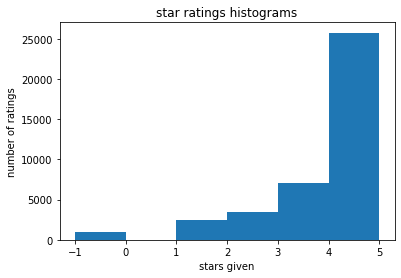

In [251]:
f, a = plt.subplots()
a.hist(ratings, bins = 6)
a.set_ylabel('number of ratings')
a.set_xlabel('stars given')
a.set_title('star ratings histograms')
plt.show()

In [255]:
def text_to_tokens(one):
    snowball = SnowballStemmer('english')
    tokenized = one.lower().split()
    e_stop = stopwords.words('english')
    without_stopw = [snowball.stem(word) for word in tokenized if word not in e_stop]

    return without_stopw

In [282]:
tfid = TfidfVectorizer(stop_words ='english', lowercase = True, )
tfidfed = tfid.fit_transform(words_english)
X = tfidfed
y = ratings.reshape(-1,1)


numpy.ndarray

In [284]:
y = list(ratings)

In [285]:
first_forest = RandomForestClassifier(oob_score=True, n_jobs =-1, n_estimators = 100)
first_forest.fit(X, y)

/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/robert/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [287]:
first_forest.oob_score

True

In [288]:
dir(first_forest)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_more_tags',
 '_required_parameters',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'estimator_params',
 'estimators_',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split

In [277]:
X

<39644x63457 sparse matrix of type '<class 'numpy.float64'>'
	with 2637227 stored elements in Compressed Sparse Row format>

In [280]:
y = ratings.reshape(-1,1)